/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Training:   0%|          | 0/500 [00:00<?, ?episode/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_80816/2571561041.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
Training: 100%|██████████| 500/500 [00:22<00:00, 22.49episode/s, Avg Reward (last 10 episodes)=2.41e+3] 


Rewards history saved
Saved shared policy to shared_policy.pth


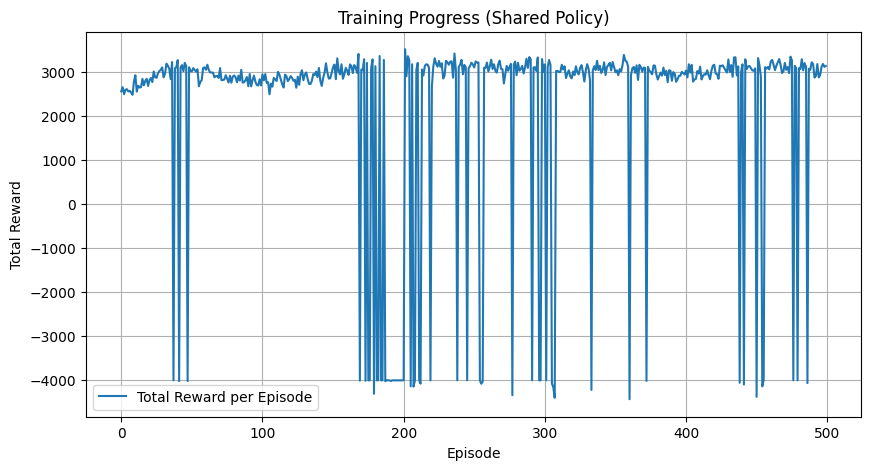

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# 假设所有Agent的观测维度和动作维度相同
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=6500):
    """
    使用REINFORCE算法的多智能体训练，每个智能体的策略网络参数共享。
    假设环境里每个智能体的观测空间大小相同、动作空间大小相同。
    """

    # 获取agents列表
    agents = env.agents
    # 以第一个智能体的观测和动作空间来初始化共享网络
    obs_dim = env.observation_space(agents[0]).shape[0]
    act_dim = env.action_space(agents[0]).n

    # 仅创建一个共享策略网络
    shared_policy = PolicyNetwork(obs_dim, act_dim)
    # 仅创建一个优化器
    optimizer = optim.Adam(shared_policy.parameters(), lr=lr)

    total_rewards_history = []

    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")
    for episode in progress_bar:
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False

        # 收集当个episode里所有agent的轨迹
        # 因为是共享网络，各agent的轨迹可以合并，也可以分别存储；这里分别存储，方便后面查看和调试
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}
        actions_history = []

        while not done_flag:
            actions = {}
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                with torch.no_grad():
                    logits = shared_policy(obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            actions_history.append([actions[agent] for agent in agents])
            
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # episode结束后，统一在这里计算损失并更新网络
        optimizer.zero_grad()
        total_loss = 0.0

        # 逐个agent计算回报、对数概率、loss，并累加
        for agent in agents:
            # 计算折扣回报
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
            action_batch = torch.LongTensor(trajectories[agent]["actions"])
            return_batch = torch.FloatTensor(returns)

            # 前向传播
            logits = shared_policy(obs_batch)
            log_probs = torch.log_softmax(logits, dim=-1)
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)

            # REINFORCE loss
            loss = -(chosen_log_probs * return_batch).mean()
            total_loss += loss

        # 反向传播并更新一次（累加所有Agent的梯度）
        total_loss.backward()
        optimizer.step()

        # 记录并可视化
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)

        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})

        if total_reward_this_episode >= reward_threshold:
            for step in actions_history:
                print(step)  # 按行输出动作选择矩阵
            print("=======!!!!!!!!!!!!!!!=======")

    return total_rewards_history, shared_policy

# 在此处引入你的自定义环境
from env_new.MAenv_shared import CustomMAEnvironment

if __name__ == "__main__":
    # 创建环境（假设有5个智能体，环境逻辑与你原代码保持一致）
    env = CustomMAEnvironment(num_agents=5, num_iterations=200, dt=0.1)
    
    # 开始训练
    rewards_history, shared_policy = train_multiagent(
        env, 
        num_episodes=500, 
        gamma=0.99, 
        lr=0.001
    )
    
    # 保存训练曲线
    np.save("rewards_history_demo_shared.npy", rewards_history)
    print("Rewards history saved")

    # 仅保存一个共享策略网络
    torch.save(shared_policy.state_dict(), "shared_policy.pth")
    print("Saved shared policy to shared_policy.pth")

    # 绘制总体回报曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress (Shared Policy)")
    plt.legend()
    plt.grid(True)
    plt.show()


Rewards history loaded successfully.
Top 1: Reward = 3633.2900000000004, Step = 2132
Top 2: Reward = 3593.919999999999, Step = 9360
Top 3: Reward = 3577.5299999999997, Step = 9356
Top 4: Reward = 3561.8199999999997, Step = 7288
Top 5: Reward = 3558.95, Step = 9967
Top 6: Reward = 3550.4799999999996, Step = 1502
Top 7: Reward = 3546.3, Step = 918
Top 8: Reward = 3544.71, Step = 6155
Top 9: Reward = 3543.99, Step = 1944
Top 10: Reward = 3543.23, Step = 9391


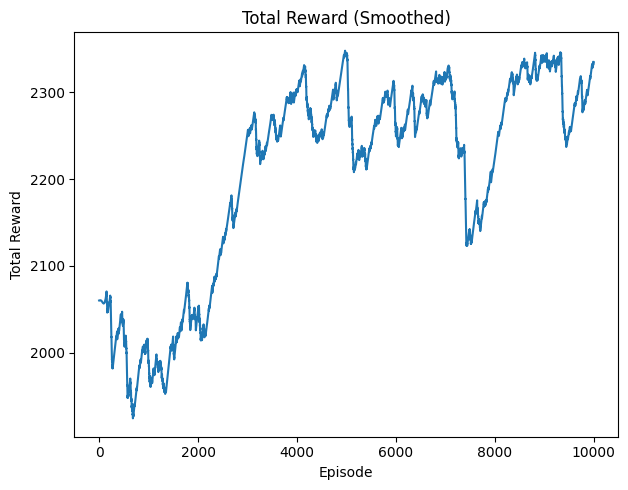

In [9]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history_lstm_demo.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.9995):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()


Training: 100%|██████████| 10000/10000 [1:22:12<00:00,  2.03episode/s, Avg Reward (last 10 episodes)=3.23e+3]

Rewards history saved
Saved shared LSTM-based policy to shared_policy_lstm.pth


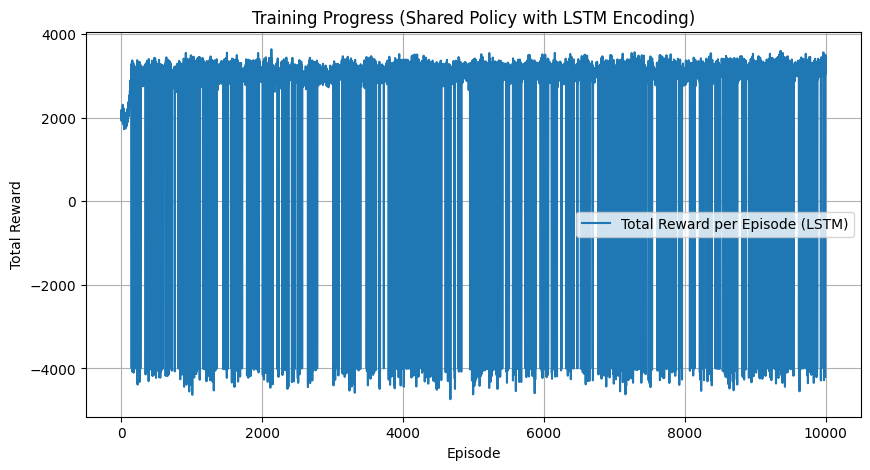

In [8]:
#利用lstm聚合智能体邻居信息

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------ 1. 先定义一个带LSTM的策略网络 ------------------ #
class LSTMPolicyNetwork(nn.Module):
    """
    先用 LSTM 处理变长的观测序列，将序列映射到一个固定维度的向量；
    然后用若干全连接层(MLP)进一步处理，输出对每个动作的 logits。
    """
    def __init__(self, 
                 lstm_hidden_size=32,   # LSTM 的隐藏层大小
                 fc_hidden_size=64,     # 后续全连接层的隐藏大小
                 action_dim=2           # 动作空间大小（此处假设离散2维动作）
                ):
        super(LSTMPolicyNetwork, self).__init__()
        # 假设每个位置是1维(即一个标量)，故 LSTM input_size=1
        # 如果你的观测中每个“序列元素”含有更多特征，则自行修改 input_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, batch_first=True)

        # 用线性层将 LSTM 输出的隐藏向量映射到更高维或直接输出
        self.fc1 = nn.Linear(lstm_hidden_size, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, fc_hidden_size)
        self.fc3 = nn.Linear(fc_hidden_size, action_dim)
    
    def forward(self, obs_array):
        """
        obs_array: 形状为 (obs_length,) 的 1D numpy/tensor，每个元素是一个标量(位置)。
        我们需要将其 reshape 成 (1, obs_length, 1) 再送入 LSTM。
        
        返回: (batch=1, action_dim) 的 logits，用于后续 softmax 采样或计算概率。
        """
        # 将 numpy array 转为 tensor，并做 reshape
        if isinstance(obs_array, np.ndarray):
            obs_tensor = torch.FloatTensor(obs_array)
        else:
            obs_tensor = obs_array  # 如果已经是 tensor，就直接用

        # (obs_length,) -> (1, obs_length, 1)
        #观测被转换为序列输入LSTM：
        obs_tensor = obs_tensor.unsqueeze(0).unsqueeze(-1)

        # LSTM 前向传播
        # output: (batch_size=1, seq_len=obs_length, hidden_size)
        # (h_n, c_n): h_n 形状 (num_layers, batch_size=1, hidden_size)
        output, (h_n, c_n) = self.lstm(obs_tensor)
        
        # 取最后一层、最后一个 time step 的隐藏向量: (hidden_size,)
        # h_n 的维度：[num_layers, batch_size, hidden_size]
        # 我们只要最后一层，并且 batch=1，所以取 h_n[-1, 0, :]
        final_hidden = h_n[-1, 0, :]

        # 经过全连接层
        x = torch.relu(self.fc1(final_hidden))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)  # (action_dim,)
        
        return logits


# ------------------ 2. 定义训练循环 (REINFORCE，多智能体) ------------------ #
def train_multiagent_with_lstm(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=6500):
    """
    使用 REINFORCE 算法 + LSTM 编码观测 的多智能体训练示例。
    假设：
    1) 环境里的每个智能体的动作空间大小相同(离散2维)。
    2) 每个智能体的观测是一串位置(包含自己和邻居)，长度可变。
    3) 我们使用共享策略网络 LSTMPolicyNetwork。
    """

    agents = env.agents  # 拿到环境中的所有智能体ID
    action_dim = env.action_space(agents[0]).n  # 假设动作空间相同，这里是2
    # 不再使用“obs_dim = env.observation_space(agents[0]).shape[0]”这种写法，
    # 因为各个智能体观测长度并不固定。

    # 创建一个共享的策略网络
    shared_policy = LSTMPolicyNetwork(lstm_hidden_size=32, fc_hidden_size=64, action_dim=action_dim)
    optimizer = optim.Adam(shared_policy.parameters(), lr=lr)

    total_rewards_history = []
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")

    for episode in progress_bar:
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False

        # 用于存储本回合的所有 (obs, action, reward) 序列
        # 这里 obs 直接存 np.array 或 list，不需要提前拼成 batch
        # 因为后面要逐步前向传播
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}

        while not done_flag:
            actions = {}
            # 对每个智能体，单独前向网络
            for agent in agents:
                # 将观测 obs[agent] 输入LSTM网络，得到 logits
                with torch.no_grad():
                    logits = shared_policy(obs[agent])  # obs[agent] 是可变长度的一维向量
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action

            next_obs, rewards, dones, infos = env.step(actions)

            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])  # 这里存可变长度的 numpy array
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])

            obs = next_obs
            done_flag = all(dones.values())

        # ------------------ 回合结束，开始计算REINFORCE的损失并更新网络 ------------------ #
        optimizer.zero_grad()
        total_loss = 0.0

        # 对每个智能体分别计算回报与损失
        for agent in agents:
            # 计算该智能体在本episode中的折扣回报
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)

            # 逐时间步前向传播，累加 REINFORCE 的 loss
            # 注意，这里因为观测维度变长，所以不能一次性打包成大矩阵，
            # 我们只能在每一个 time step 单独 forward，然后收集 log_prob
            time_step_num = len(trajectories[agent]["obs"])
            log_probs = []

            for t in range(time_step_num):
                obs_array = trajectories[agent]["obs"][t]       # 取出可变长度观测
                action = trajectories[agent]["actions"][t]     # 该时刻动作
                # 前向网络
                logits = shared_policy(obs_array)
                probs = torch.softmax(logits, dim=-1)
                log_prob = torch.log(probs[action])
                log_probs.append(log_prob)

            # 现在我们有了 log_probs[t] 和 returns[t]
            # REINFORCE的目标： sum_t [ - log_prob(a_t|obs_t) * G_t ]
            # 因为这里做的是简化实现，所以直接一次性求和
            loss_agent = 0.0
            for t in range(time_step_num):
                loss_agent += - log_probs[t] * returns[t]

            total_loss += loss_agent

        # 对所有智能体累加的 total_loss 进行一次反向传播
        total_loss.backward()
        optimizer.step()

        # 记录本episode的总奖励(所有智能体奖励之和)
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)

        # 进度条上显示最近10个episode的平均回报，便于观察训练动态
        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})

        # 若达到某个阈值，可以提前打印或做别的处理
        if total_reward_this_episode >= reward_threshold:
            print(f"Episode {episode}取得回报达到阈值: {total_reward_this_episode}")
            break

    return total_rewards_history, shared_policy


# ------------------ 3. 下面演示如何使用该训练函数 ------------------ #
if __name__ == "__main__":
    # 假设你已经按照之前的方式，定义了一个类似 CustomMAEnvironment3 的环境
    # 且其 step() / reset() / observation_space() / action_space() 等接口可用
    # 这里仅以你示例中的环境来演示
    from env_new.MAenv_3 import CustomMAEnvironment3
    
    # 创建环境（假设有5个智能体，环境逻辑与你原代码保持一致）
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)

    # 开始训练
    rewards_history, shared_policy = train_multiagent_with_lstm(
        env,
        num_episodes=10000,   # 可根据需要改大一些
        gamma=0.99,
        lr=0.001
    )
    
    # 保存训练曲线
    np.save("rewards_history_lstm_demo.npy", rewards_history)
    print("Rewards history saved")

    # 保存共享策略网络
    torch.save(shared_policy.state_dict(), "shared_policy_lstm.pth")
    print("Saved shared LSTM-based policy to shared_policy_lstm.pth")

    # 绘制总体回报曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode (LSTM)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress (Shared Policy with LSTM Encoding)")
    plt.legend()
    plt.grid(True)
    plt.show()
